# Reading File
1)Convert the date into datetimes format

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
df = pd.read_csv("train_5CLrC8b/train.csv")
test = pd.read_csv('test.csv')
import pandas as pd
pd.set_option('display.max_columns', 500)

df.checkin_date = pd.to_datetime(df.checkin_date, format="%d/%m/%y")

df.checkout_date = pd.to_datetime(df.checkout_date, format="%d/%m/%y")

df.booking_date= pd.to_datetime(df.booking_date, format="%d/%m/%y")

test.checkin_date = pd.to_datetime(test.checkin_date, format="%d/%m/%y")

test.checkout_date = pd.to_datetime(test.checkout_date, format="%d/%m/%y")

test.booking_date= pd.to_datetime(test.booking_date, format="%d/%m/%y")

df.columns



Index(['reservation_id', 'booking_date', 'checkin_date', 'checkout_date',
       'channel_code', 'main_product_code', 'numberofadults',
       'numberofchildren', 'persontravellingid', 'resort_region_code',
       'resort_type_code', 'room_type_booked_code', 'roomnights',
       'season_holidayed_code', 'state_code_residence', 'state_code_resort',
       'total_pax', 'member_age_buckets', 'booking_type_code', 'memberid',
       'cluster_code', 'reservationstatusid_code', 'resort_id',
       'amount_spent_per_room_night_scaled'],
      dtype='object')

# Making DateTime Features

In [2]:

def dt_feat(train,date_col):
    print(train.shape)
    train[date_col+'week_day'] = train[date_col].dt.dayofweek
    train[date_col+'month'] = train[date_col].dt.month
    train[date_col+'is_month_end'] = train[date_col].dt.is_month_end
    train[date_col+'dayofyear'] = train[date_col].dt.dayofyear
    train[date_col+'day'] = train[date_col].dt.day
    train[date_col+'year'] = train[date_col].dt.year
    train[date_col+'weekyear'] = train[date_col].dt.weekofyear




    return train

train1 =dt_feat(df,'checkin_date')

train1=dt_feat(train1,'checkout_date')

train1=dt_feat(train1,'booking_date')
df = train1.copy()

train1 =dt_feat(test,'checkin_date')

train1=dt_feat(train1,'checkout_date')

train1=dt_feat(train1,'booking_date')
test = train1.copy()

df.columns

cat_cols = [f for f in df.columns if (df[f].dtype == 'object' and f not in ['reservation_id'])]



(341424, 24)
(341424, 31)
(341424, 38)
(146765, 23)
(146765, 30)
(146765, 37)


In [4]:
train = df.copy()

### LabelEncodig the categorical Variables

In [5]:
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

### Making very Important Features like 
1 Number of days stayed<br>


In [6]:
train['in_book']=train.checkin_date-train.booking_date
test['in_book']=test.checkin_date-test.booking_date
train['in_out'] = train.checkout_date-train.checkin_date
test['in_out'] = test.checkout_date-test.checkin_date
def day_get(x):
    return x.days
train.in_out = train.in_out.apply(day_get)
test.in_out = test.in_out.apply(day_get)
train.in_book = train.in_book.apply(day_get)
test.in_book = test.in_book.apply(day_get)

In [7]:
train_bkp=train.copy()
test_bkp=test.copy()

In [8]:
print(train.shape)
print(test.shape)

(341424, 47)
(146765, 46)


## Making Groupby feat

In [10]:
merge = pd.concat([train_bkp,test_bkp])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [11]:
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','memberid']).reservation_id.count()).reset_index(),suffixes=('','res_mem'),on=['resort_id','memberid'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id']).reservation_id.count()).reset_index(),suffixes=('','_x_res'),on='resort_id',how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','checkout_dateyear','checkout_datemonth']).reservation_id.count()).reset_index(),suffixes=('','_res_month'),on=['resort_id','checkout_dateyear','checkout_datemonth'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid']).reservation_id.count()).reset_index(),suffixes=('','mem'),on=['memberid'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid','checkout_dateyear']).reservation_id.count()).reset_index(),suffixes=('','mem_year'),on=['memberid','checkout_dateyear'],how='left')

merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id']).roomnights.median()).reset_index(),suffixes=('','res_amount_median'),on=['resort_id'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id']).roomnights.max()).reset_index(),suffixes=('','res_amount_max'),on=['resort_id'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id']).roomnights.min()).reset_index(),suffixes=('','res_amount_min'),on=['resort_id'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id']).roomnights.std()).reset_index(),suffixes=('','res_amount_std'),on=['resort_id'],how='left')

#0.9651884690956651


merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','memberid']).roomnights.median()).reset_index(),suffixes=('','res_mem_amount_median'),on=['resort_id','memberid'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','memberid']).roomnights.max()).reset_index(),suffixes=('','res_mem_amount_max'),on=['resort_id','memberid'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','memberid']).roomnights.min()).reset_index(),suffixes=('','res_mem_amount_min'),on=['resort_id','memberid'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','memberid']).roomnights.std()).reset_index(),suffixes=('','res_mem_amount_std'),on=['resort_id','memberid'],how='left')

merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid']).roomnights.median()).reset_index(),suffixes=('','mem_amount_median'),on=['memberid'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid']).roomnights.max()).reset_index(),suffixes=('','mem_amount_max'),on=['memberid'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid']).roomnights.min()).reset_index(),suffixes=('','mem_amount_min'),on=['memberid'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid']).roomnights.std()).reset_index(),suffixes=('','mem_amount_std'),on=['memberid'],how='left')


merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','room_type_booked_code']).reservation_id.count()).reset_index(),suffixes=('','_res_type'),on=['resort_id','room_type_booked_code'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','checkout_datemonth','room_type_booked_code']).reservation_id.count()).reset_index(),suffixes=('','_res_code_month_x'),on=['resort_id','checkout_datemonth','room_type_booked_code'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','main_product_code']).reservation_id.count()).reset_index(),suffixes=('','_res_main_code'),on=['resort_id','main_product_code'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['channel_code','checkout_dateyear','checkout_datemonth']).reservation_id.count()).reset_index(),suffixes=('','channel_check_yearmonth'),on=['channel_code','checkout_dateyear','checkout_datemonth'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['checkout_dateyear','checkout_datemonth']).reservation_id.count()).reset_index(),suffixes=('','check_Date_month'),on=['checkout_dateyear','checkout_datemonth'],how='left')

#0.9651884690956651


merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','memberid']).in_out.median()).reset_index(),suffixes=('','res_meminoutt_median'),on=['resort_id','memberid'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','memberid']).in_out.max()).reset_index(),suffixes=('','res_mem_inout_max'),on=['resort_id','memberid'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','memberid']).in_out.min()).reset_index(),suffixes=('','res_mem_inout_min'),on=['resort_id','memberid'],how='left')

merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','memberid']).in_out.std()).reset_index(),suffixes=('','res_meminoutt_std'),on=['resort_id','memberid'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid']).in_out.median()).reset_index(),suffixes=('','mem_inout_median'),on=['memberid'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid']).in_out.max()).reset_index(),suffixes=('','mem_inout_max'),on=['memberid'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid']).in_out.min()).reset_index(),suffixes=('','mem_inout_min'),on=['memberid'],how='left')

merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid']).in_out.std()).reset_index(),suffixes=('','mem_inout_std'),on=['memberid'],how='left')



merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid']).total_pax.median()).reset_index(),suffixes=('','mem_inout_median_pax'),on=['memberid'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid']).total_pax.max()).reset_index(),suffixes=('','mem_inout_max_pax'),on=['memberid'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid']).total_pax.min()).reset_index(),suffixes=('','mem_inout_min_pax'),on=['memberid'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid']).total_pax.std()).reset_index(),suffixes=('','mem_inout_std_pax'),on=['memberid'],how='left')



merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id']).total_pax.median()).reset_index(),suffixes=('','res_inout_median_pax'),on=['resort_id'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id']).total_pax.max()).reset_index(),suffixes=('','res_inout_max_pax'),on=['resort_id'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id']).total_pax.min()).reset_index(),suffixes=('','res_inout_min_pax'),on=['resort_id'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id']).total_pax.std()).reset_index(),suffixes=('','res_inout_std_pax'),on=['resort_id'],how='left')



# merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','memberid']).total_pax.median()).reset_index(),suffixes=('','mem_res_inout_median_pax'),on=['resort_id','memberid'],how='left')
# merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','memberid']).total_pax.max()).reset_index(),suffixes=('','mem_res_inout_max_pax'),on=['resort_id','memberid'],how='left')
# merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','memberid']).total_pax.min()).reset_index(),suffixes=('','mem_res_inout_min_pax'),on=['resort_id','memberid'],how='left')
# merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','memberid']).total_pax.std()).reset_index(),suffixes=('','mem_res_inout_std_pax'),on=['resort_id','memberid'],how='left')




merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','main_product_code']).reservation_id.count()).reset_index(),suffixes=('','res_memmain_product_code'),on=['resort_id','main_product_code'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['main_product_code']).reservation_id.count()).reset_index(),suffixes=('','_x_resmain_product_code'),on='main_product_code',how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid','resort_id','main_product_code']).reservation_id.count()).reset_index(),suffixes=('','memjknknk'),on=['memberid','resort_id','main_product_code'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid','main_product_code']).reservation_id.count()).reset_index(),suffixes=('','mem_yearmain_product_code'),on=['memberid','main_product_code'],how='left')



#merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','checkout_dateyear','checkin_dateweekyear']).total_pax.count()).reset_index(),suffixes=('','res_inout_std_pax','week_year'),on=['resort_id','checkout_dateyear','checkin_dateweekyear'],how='left')

merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','checkout_dateyear','checkin_dateweekyear']).reservation_id.count()).reset_index(),suffixes=('','_res_month_week_year'),on=['resort_id','checkout_dateyear','checkin_dateweekyear'],how='left')



merge = merge.merge(pd.DataFrame(merge.groupby(by=['memberid','checkout_dateyear','checkin_dateweekyear']).reservation_id.count()).reset_index(),suffixes=('','_res_month_week_year_member'),on=['memberid','checkout_dateyear','checkin_dateweekyear'],how='left')



import datetime

merge['booking_dayes'] = (datetime.datetime.today()-merge['booking_date']).dt.days
merge['checkin_dayes'] = (datetime.datetime.today()-merge['checkin_date']).dt.days
merge['checkout_dayes'] = (datetime.datetime.today()-merge['checkout_date']).dt.days



merge['rooms_booked_per_night'] = merge.in_out/merge.roomnights
merge['rooms_bookinf_per_night'] = merge.in_book/merge.roomnights


merge = merge.merge(pd.DataFrame(merge.groupby(by=['state_code_residence']).total_pax.median()).reset_index(),suffixes=('','mem_inout_median_pax_state_code'),on=['state_code_residence'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['state_code_residence']).total_pax.max()).reset_index(),suffixes=('','mem_inout_max_pax_state_code'),on=['state_code_residence'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['state_code_residence']).total_pax.min()).reset_index(),suffixes=('','mem_inout_min_pax_state_code'),on=['state_code_residence'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['state_code_residence']).total_pax.std()).reset_index(),suffixes=('','mem_inout_std_pax_state_code'),on=['state_code_residence'],how='left')





merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','state_code_residence']).roomnights.median()).reset_index(),suffixes=('','res_mem_amount_medianstate_code_resid'),on=['resort_id','state_code_residence'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','state_code_residence']).roomnights.max()).reset_index(),suffixes=('','res_mem_amount_maxstate_code_resid'),on=['resort_id','state_code_residence'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','state_code_residence']).roomnights.min()).reset_index(),suffixes=('','res_mem_amount_minstate_code_resid'),on=['resort_id','state_code_residence'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','state_code_residence']).roomnights.std()).reset_index(),suffixes=('','res_mem_amount_stdstate_code_resid'),on=['resort_id','state_code_residence'],how='left')

merge = merge.merge(pd.DataFrame(merge.groupby(by=['state_code_residence']).roomnights.median()).reset_index(),suffixes=('','mem_amount_medianstate_code_resid'),on=['state_code_residence'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['state_code_residence']).roomnights.max()).reset_index(),suffixes=('','mem_amount_maxstate_code_resid'),on=['state_code_residence'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['state_code_residence']).roomnights.min()).reset_index(),suffixes=('','mem_amount_minstate_code_resid'),on=['state_code_residence'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['state_code_residence']).roomnights.std()).reset_index(),suffixes=('','mem_amount_stdstate_code_resid'),on=['state_code_residence'],how='left')



merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','state_code_residence']).in_out.median()).reset_index(),suffixes=('','res_meminoutt_medianstate_code_resid'),on=['resort_id','state_code_residence'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','state_code_residence']).in_out.max()).reset_index(),suffixes=('','res_mem_inout_maxstate_code_resid'),on=['resort_id','state_code_residence'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','state_code_residence']).in_out.min()).reset_index(),suffixes=('','res_mem_inout_minstate_code_resid'),on=['resort_id','state_code_residence'],how='left')

merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','state_code_residence']).in_out.std()).reset_index(),suffixes=('','res_meminoutt_stdstate_code_resid'),on=['resort_id','state_code_residence'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['state_code_residence']).in_out.median()).reset_index(),suffixes=('','mem_inout_medianstate_code_resid'),on=['state_code_residence'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['state_code_residence']).in_out.max()).reset_index(),suffixes=('','mem_inout_maxstate_code_resid'),on=['state_code_residence'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['state_code_residence']).in_out.min()).reset_index(),suffixes=('','mem_inout_minstate_code_resid'),on=['state_code_residence'],how='left')




##  Difference between time when resort was previously/next booked <br>
1) When person A books the time of last past booking of that resort
2) When person A books the time when next booking will made. and so on.....

In [12]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import os

predictors=[]

def do_prev_Click( df,agg_suffix='prevClick', agg_type='float32'):

    print(f">> \nExtracting {agg_suffix} time calculation features...\n")
    
    GROUP_BY_NEXT_CLICKS = [
    
     {'groupby': ['resort_id', 'memberid']},
     {'groupby': ['resort_id']},
        
    ]

    # Calculate the time to next click for each group
    for spec in GROUP_BY_NEXT_CLICKS:
    
       # Name of new feature
        new_feature = '{}_{}'.format('_'.join(spec['groupby']),agg_suffix)    
    
        # Unique list of features to select
        all_features = spec['groupby'] + ['booking_date']

        # Run calculation
        print(f">> Grouping by {spec['groupby']}, and saving time to {agg_suffix} in: {new_feature}")
        df[new_feature] = (df.booking_date - df[all_features].groupby(spec[
                'groupby']).booking_date.shift(+1) ).dt.days.astype(agg_type)
        
        predictors.append(new_feature)
        gc.collect()
    return (df)    


def do_next_Click( df,agg_suffix='nextClick', agg_type='float32'):
    
    print(f">> \nExtracting {agg_suffix} time calculation features...\n")
    
    GROUP_BY_NEXT_CLICKS = [
    
    # V3
   
     {'groupby': ['resort_id', 'memberid']},
     {'groupby': ['resort_id']},
    # {'groupby': ['memberid']}
        ]

    # Calculate the time to next click for each group
    for spec in GROUP_BY_NEXT_CLICKS:
    
       # Name of new feature
        new_feature = '{}_{}'.format('_'.join(spec['groupby']),agg_suffix)    
    
        # Unique list of features to select
        all_features = spec['groupby'] + ['booking_date']

        # Run calculation
        print(f">> Grouping by {spec['groupby']}, and saving time to {agg_suffix} in: {new_feature}")
        df[new_feature] = (df[all_features].groupby(spec[
            'groupby']).booking_date.shift(-1) - df.booking_date).dt.days.astype(agg_type)
        
        #predictors.webpage_idend(new_feature)
        gc.collect()
    return (df)







/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [13]:
merge = do_prev_Click(merge)

>> 
Extracting prevClick time calculation features...

>> Grouping by ['resort_id', 'memberid'], and saving time to prevClick in: resort_id_memberid_prevClick
>> Grouping by ['resort_id'], and saving time to prevClick in: resort_id_prevClick


In [14]:
merge = do_next_Click(merge)

>> 
Extracting nextClick time calculation features...

>> Grouping by ['resort_id', 'memberid'], and saving time to nextClick in: resort_id_memberid_nextClick
>> Grouping by ['resort_id'], and saving time to nextClick in: resort_id_nextClick


In [15]:
merge.shape

(488189, 119)

### Making the categories of columns

In [16]:
categor_col =['member_age_buckets','memberid','resort_id',
 'cluster_code',
 'reservationstatusid_code',
 'resort_id',
 'channel_code',
 'main_product_code',
 'persontravellingid',
 'resort_region_code',
 'resort_type_code',
 'room_type_booked_code',
 'season_holidayed_code',
 'state_code_residence',
 'state_code_resort',
 'member_age_buckets',
 'booking_type_code']

for i in categor_col:
    print(i,train[i].nunique())

for i in categor_col:
    merge[i] = merge[i].astype('category')

member_age_buckets 10
memberid 101327
resort_id 32
cluster_code 6
reservationstatusid_code 4
resort_id 32
channel_code 3
main_product_code 5
persontravellingid 6
resort_region_code 3
resort_type_code 7
room_type_booked_code 6
season_holidayed_code 4
state_code_residence 37
state_code_resort 11
member_age_buckets 10
booking_type_code 2


In [17]:
merge = merge.merge(pd.DataFrame(merge.groupby(by=['state_code_residence']).reservation_id.count()).reset_index(),suffixes=('','_x_res_mem_state_score'),on=['state_code_residence'],how='left')
merge = merge.merge(pd.DataFrame(merge.groupby(by=['resort_id','state_code_residence']).reservation_id.count()).reset_index(),suffixes=('','_x_res_mem_state_scoreresort_id'),on=['resort_id','state_code_residence'],how='left')


#### Getting train and Test out of Merged File

In [18]:
train = merge.loc[merge.amount_spent_per_room_night_scaled.notnull()]
test = merge.loc[merge.amount_spent_per_room_night_scaled.isnull()]

In [19]:
X= train.drop(['reservation_id','booking_date','checkin_date','checkout_date','amount_spent_per_room_night_scaled','memberid'],axis=1)

y=train.amount_spent_per_room_night_scaled

### Dividing on the Basis of 
1)Random<br>
2)Unique MemberIds<br>
I cross - validated my model on both the cross validation technniques which resulted in very robust Model.

In [20]:
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.2,random_state=3)

from lightgbm import LGBMRegressor

clf=LGBMRegressor(n_estimators=100)

from catboost import CatBoostRegressor

#clf=CatBoostRegressor()

In [21]:
clf=LGBMRegressor(n_estimators=100,learning_rate=.12,subsample=1,reg_alpha=25,min_child_weight=49)



In [24]:
clf.fit(train_x,train_y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.12, max_depth=-1,
       min_child_samples=20, min_child_weight=49, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=25, reg_lambda=0.0, silent=True,
       subsample=1, subsample_for_bin=200000, subsample_freq=0)

#### RMSE score comes out to be ~ 96.1 for 115 features on default params

In [26]:
from sklearn.metrics import mean_squared_error

import numpy as np

print(np.sqrt(mean_squared_error(test_y,clf.predict(test_x))))

0.9611527041325448


##### Further tuning for LGB model

In [28]:
clf=LGBMRegressor(n_estimators=1000,learning_rate=.06,subsample=0.9,reg_alpha=25,min_child_weight=49)
clf=LGBMRegressor()
clf=LGBMRegressor(n_estimators=1000,learning_rate=.12,subsample=1,reg_alpha=5,min_child_weight=1)


clf.fit(train_x,train_y,eval_set=[(test_x,test_y)],eval_metric='rmse',verbose=100,early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.924557	valid_0's rmse: 0.961539
[200]	valid_0's l2: 0.923346	valid_0's rmse: 0.960909
[300]	valid_0's l2: 0.923464	valid_0's rmse: 0.96097
Early stopping, best iteration is:
[208]	valid_0's l2: 0.923284	valid_0's rmse: 0.960877


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.12, max_depth=-1,
       min_child_samples=20, min_child_weight=1, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=5, reg_lambda=0.0, silent=True,
       subsample=1, subsample_for_bin=200000, subsample_freq=0)

#### Testing Cross Validation Startegy-2

In [29]:
test_x = train.iloc[:137148].drop(['reservation_id','booking_date','checkin_date','checkout_date','amount_spent_per_room_night_scaled','memberid'],axis=1)
train_x = train.iloc[137148:].drop(['reservation_id','booking_date','checkin_date','checkout_date','amount_spent_per_room_night_scaled','memberid'],axis=1)
test_y = train.iloc[:137148].amount_spent_per_room_night_scaled
train_y = train.iloc[137148:].amount_spent_per_room_night_scaled

In [30]:
clf=LGBMRegressor(n_estimators=717,learning_rate=.05,subsample=0.9,reg_alpha=25,min_child_weight=49)
clf.fit(train_x,train_y,eval_set=[(test_x,test_y)],eval_metric='rmse',verbose=100,early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.887848	valid_0's rmse: 0.942257
[200]	valid_0's l2: 0.881577	valid_0's rmse: 0.938924
[300]	valid_0's l2: 0.880875	valid_0's rmse: 0.93855
[400]	valid_0's l2: 0.880975	valid_0's rmse: 0.938603
Early stopping, best iteration is:
[350]	valid_0's l2: 0.880857	valid_0's rmse: 0.93854


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=49, min_split_gain=0.0,
       n_estimators=717, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=25, reg_lambda=0.0, silent=True,
       subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

#### Fitting the tuned model on Final training Set

In [32]:
clf=LGBMRegressor(n_estimators=717,learning_rate=.05,subsample=0.9,reg_alpha=25,min_child_weight=49)
clf.fit(X,y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=49, min_split_gain=0.0,
       n_estimators=717, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=25, reg_lambda=0.0, silent=True,
       subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

#### Prediction 1 : Single Model LGB

In [33]:
pred_test_lgb_single_model = clf.predict(test[X.columns])

In [34]:
pred_test_lgb_single_model

array([8.44966797, 7.40593963, 7.55029077, ..., 8.63509013, 8.36026112,
       7.47302073])

#### Single Best Light GBM Model

In [35]:
sub = pd.read_csv('sample_submission.csv')

sub.amount_spent_per_room_night_scaled=pred_test_lgb_single_model
sub.to_csv('single_lgb_model.csv',index=None)




#### Fitting Single Best  Catboost Model

In [37]:
try:
    X.drop('target',axis=1,inplace=True)
except:
    print('Run Next Cell')

Run Next Cell


In [38]:
MAX_ROUNDS = 4000
OPTIMIZE_ROUNDS = True
LEARNING_RATE = 0.05
model = CatBoostRegressor(verbose=100,
    learning_rate=LEARNING_RATE, 
    l2_leaf_reg = 8, 
    iterations = MAX_ROUNDS,
#    verbose = True,
    loss_function='RMSE',
)




#### validating and finding the optimal number of iterations for the Catboost Model
###### ~1231 is optimal for Catboost model

In [88]:
fit_model = model.fit(train_x, train_y, 
                               eval_set=[(test_x,test_y)],
                               use_best_model=True
                             )

0:	learn: 7.4396353	test: 7.3779558	best: 7.3779558 (0)	total: 93.6ms	remaining: 6m 14s
100:	learn: 1.0038490	test: 0.9597464	best: 0.9597464 (100)	total: 8.34s	remaining: 5m 21s
200:	learn: 0.9891052	test: 0.9458932	best: 0.9458932 (200)	total: 16.3s	remaining: 5m 8s
300:	learn: 0.9843892	test: 0.9430126	best: 0.9430126 (300)	total: 23.8s	remaining: 4m 52s
400:	learn: 0.9811663	test: 0.9416773	best: 0.9416723 (399)	total: 33.1s	remaining: 4m 57s
500:	learn: 0.9787529	test: 0.9411042	best: 0.9411042 (500)	total: 42.8s	remaining: 4m 58s
600:	learn: 0.9763226	test: 0.9405696	best: 0.9405696 (600)	total: 50.6s	remaining: 4m 46s
700:	learn: 0.9744956	test: 0.9403179	best: 0.9403166 (699)	total: 1m	remaining: 4m 44s
800:	learn: 0.9726677	test: 0.9401079	best: 0.9400628 (792)	total: 1m 11s	remaining: 4m 44s
900:	learn: 0.9709539	test: 0.9400918	best: 0.9400370 (841)	total: 1m 19s	remaining: 4m 34s
1000:	learn: 0.9692047	test: 0.9399658	best: 0.9399658 (1000)	total: 1m 28s	remaining: 4m 23s
1

KeyboardInterrupt: 

### Single Catboost Model

In [39]:
MAX_ROUNDS = 1231
OPTIMIZE_ROUNDS = True
LEARNING_RATE = 0.05
model = CatBoostRegressor(verbose=100,
    learning_rate=LEARNING_RATE, 
    l2_leaf_reg = 8, 
    iterations = MAX_ROUNDS,
#    verbose = True,
    loss_function='RMSE',
)

fit_model = model.fit(X,y)

0:	learn: 7.4155573	total: 198ms	remaining: 4m 2s
100:	learn: 0.9842473	total: 14.8s	remaining: 2m 45s
200:	learn: 0.9709161	total: 30s	remaining: 2m 33s
300:	learn: 0.9668858	total: 42.4s	remaining: 2m 11s
400:	learn: 0.9644321	total: 54.6s	remaining: 1m 52s
500:	learn: 0.9624945	total: 1m 6s	remaining: 1m 36s
600:	learn: 0.9608910	total: 1m 19s	remaining: 1m 23s
700:	learn: 0.9595212	total: 1m 32s	remaining: 1m 9s
800:	learn: 0.9582312	total: 1m 45s	remaining: 56.4s
900:	learn: 0.9569728	total: 1m 57s	remaining: 43s
1000:	learn: 0.9557936	total: 2m 11s	remaining: 30.1s
1100:	learn: 0.9546238	total: 2m 23s	remaining: 17s
1200:	learn: 0.9534425	total: 2m 37s	remaining: 3.92s
1230:	learn: 0.9531279	total: 2m 40s	remaining: 0us


In [40]:
pred_catboost_model=model.predict(test[X.columns])

In [41]:
pred_catboost_model

array([8.38006997, 7.42584487, 7.52780001, ..., 8.53768314, 8.04933145,
       7.29158108])

#### Making 5 FoldPredictions for Catboost Model

In [189]:
K = 5
kf = KFold(n_splits = K, random_state = 1, shuffle = True)
y_valid_pred = 0*y
y_test_pred = 0
for i, (train_index, test_index) in enumerate(kf.split(X)):
    
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:], X.iloc[test_index,:]
    print( "\nFold ", i)
    
    # Run model for this fold
    if OPTIMIZE_ROUNDS:
        fit_model = model.fit(X_train, y_train, 
                               eval_set=[(X_valid, y_valid)],
                               use_best_model=True
                             )
        print( "  N trees = ", model.tree_count_ )
    else:
        fit_model = model.fit( X_train, y_train )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict(X_valid)
    print( "  Gini = ", np.sqrt(mean_squared_error(y_valid, pred) ))
    y_valid_pred.iloc[test_index] = pred
    
    # Accumulate test set predictions
    y_test_pred += fit_model.predict(x_test)
    
y_test_pred /= K  # Average test set predictions


Fold  0
0:	learn: 7.4141836	test: 7.4214446	best: 7.4214446 (0)	total: 110ms	remaining: 3m 39s
100:	learn: 0.9865132	test: 0.9896582	best: 0.9896582 (100)	total: 9.74s	remaining: 3m 3s
200:	learn: 0.9718449	test: 0.9764771	best: 0.9764771 (200)	total: 18.2s	remaining: 2m 43s
300:	learn: 0.9673192	test: 0.9730701	best: 0.9730701 (300)	total: 26.1s	remaining: 2m 27s
400:	learn: 0.9648425	test: 0.9717942	best: 0.9717942 (400)	total: 33.8s	remaining: 2m 14s
500:	learn: 0.9629156	test: 0.9709697	best: 0.9709697 (500)	total: 41.5s	remaining: 2m 4s
600:	learn: 0.9613595	test: 0.9703420	best: 0.9703420 (600)	total: 49s	remaining: 1m 54s
700:	learn: 0.9598764	test: 0.9699402	best: 0.9699391 (699)	total: 56.8s	remaining: 1m 45s
800:	learn: 0.9584390	test: 0.9695649	best: 0.9695649 (800)	total: 1m 4s	remaining: 1m 36s
900:	learn: 0.9572336	test: 0.9692826	best: 0.9692802 (895)	total: 1m 12s	remaining: 1m 28s
1000:	learn: 0.9559975	test: 0.9690703	best: 0.9690703 (1000)	total: 1m 19s	remaining: 1

100:	learn: 0.9862354	test: 0.9919600	best: 0.9919600 (100)	total: 9.65s	remaining: 3m 1s
200:	learn: 0.9716066	test: 0.9778498	best: 0.9778498 (200)	total: 18.1s	remaining: 2m 42s
300:	learn: 0.9671280	test: 0.9741392	best: 0.9741392 (300)	total: 26.2s	remaining: 2m 27s
400:	learn: 0.9643527	test: 0.9725154	best: 0.9725154 (400)	total: 34s	remaining: 2m 15s
500:	learn: 0.9622759	test: 0.9715804	best: 0.9715804 (500)	total: 42s	remaining: 2m 5s
600:	learn: 0.9605007	test: 0.9708873	best: 0.9708860 (599)	total: 49.8s	remaining: 1m 55s
700:	learn: 0.9590097	test: 0.9705038	best: 0.9704969 (697)	total: 57.3s	remaining: 1m 46s
800:	learn: 0.9575842	test: 0.9701045	best: 0.9701045 (800)	total: 1m 5s	remaining: 1m 37s
900:	learn: 0.9562200	test: 0.9698063	best: 0.9698027 (896)	total: 1m 13s	remaining: 1m 29s
1000:	learn: 0.9549968	test: 0.9696009	best: 0.9696009 (1000)	total: 1m 21s	remaining: 1m 21s
1100:	learn: 0.9537004	test: 0.9693528	best: 0.9693528 (1100)	total: 1m 29s	remaining: 1m 12

In [190]:
y_test_fold_cat = y_test_pred

array([8.35435413, 7.40192963, 7.50145624, ..., 8.50680044, 8.12733681,
       7.22221566])

In [42]:
pd.DataFrame(clf.feature_importances_,index=train_x.columns).sort_values(by=0)

,0
roomnightsmem_amount_minstate_code_resid,0
in_outmem_inout_medianstate_code_resid,0
total_paxres_inout_min_pax,0
reservation_idres_memmain_product_code,0
roomnightsres_amount_min,0
in_outres_mem_inout_minstate_code_resid,0
total_paxmem_inout_min_pax_state_code,0
checkout_dateis_month_end,0
roomnightsmem_amount_medianstate_code_resid,0
resort_type_code,0


In [43]:
x_test = test[X.columns]

#### Making 5Fold prediction Model for LGB dataset

In [49]:
FEATS_EXCLUDED=['target']

In [50]:
try:
    X.drop('target',axis=1,inplace=True)
except:
    print("Not there")

Not there


In [54]:
categor_col =cat_cols+[
       'channel_code',
            'main_product_code', 
      'persontravellingid', 'resort_region_code',
       'resort_type_code', 'room_type_booked_code', 
       'season_holidayed_code', 'state_code_residence', 'state_code_resort',
       'member_age_buckets', 'booking_type_code', 'memberid',
       ]

In [55]:
categor_col.remove('memberid')
categor_col.remove('memberid')

In [56]:
import datetime
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import warnings

from contextlib import contextmanager
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold

def kfold_lightgbm(train_df, test_df, num_folds, y,stratified = False, debug= False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    train_df['target']=y
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # set data structure
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               free_raw_data=False)
        params = {"objective" : "regression", "metric" : "rmse", 'n_estimators':3000, 'early_stopping_rounds':200,
              "num_leaves" : 31, "learning_rate" : 0.05, "bagging_fraction" : 0.9,
               "bagging_seed" : 0, "num_threads" : 4,"colsample_bytree" : 0.8,"lambda_l1": 25,"min_child_weight" : 44.97
          ,"min_child_samples": 5,
             }



        reg = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_test],
                        valid_names=['train', 'test'],
                        num_boost_round=10000,
                        early_stopping_rounds= 200,
                        verbose_eval=100,
            categorical_feature=categor_col
                        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    # display importances
    display_importances(feature_importance_df)

    if not debug:
        # save submission file
        return sub_preds




Starting LightGBM. Train shape: (341424, 115), test shape: (146765, 121)


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'channel_code', 'cluster_code', 'main_product_code', 'member_age_buckets', 'member_age_buckets', 'persontravellingid', 'reservationstatusid_code', 'resort_id', 'resort_region_code', 'resort_type_code', 'room_type_booked_code', 'season_holidayed_code', 'state_code_residence', 'state_code_resort']
  'New categorical_feature is {}'.format(sorted(list(categorical_feat

Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.962849	test's rmse: 0.972401
[200]	train's rmse: 0.953202	test's rmse: 0.96843
[300]	train's rmse: 0.9473	test's rmse: 0.967665
[400]	train's rmse: 0.942733	test's rmse: 0.967395
[500]	train's rmse: 0.938358	test's rmse: 0.967282
[600]	train's rmse: 0.934283	test's rmse: 0.967164
[700]	train's rmse: 0.930437	test's rmse: 0.967097
[800]	train's rmse: 0.926429	test's rmse: 0.967073
[900]	train's rmse: 0.922624	test's rmse: 0.967024
[1000]	train's rmse: 0.918783	test's rmse: 0.967028
Early stopping, best iteration is:
[876]	train's rmse: 0.923496	test's rmse: 0.966996
Fold  1 RMSE : 0.966996


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'channel_code', 'cluster_code', 'main_product_code', 'member_age_buckets', 'member_age_buckets', 'persontravellingid', 'reservationstatusid_code', 'resort_id', 'resort_region_code', 'resort_type_code', 'room_type_booked_code', 'season_holidayed_code', 'state_code_residence', 'state_code_resort']
  'New categorical_feature is {}'.format(sorted(list(categorical_feat

Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.963517	test's rmse: 0.970017
[200]	train's rmse: 0.953886	test's rmse: 0.966038
[300]	train's rmse: 0.947987	test's rmse: 0.965212
[400]	train's rmse: 0.943171	test's rmse: 0.964731
[500]	train's rmse: 0.938856	test's rmse: 0.964568
[600]	train's rmse: 0.934806	test's rmse: 0.964424
[700]	train's rmse: 0.930923	test's rmse: 0.964285
[800]	train's rmse: 0.92698	test's rmse: 0.964171
[900]	train's rmse: 0.923232	test's rmse: 0.964184
[1000]	train's rmse: 0.919596	test's rmse: 0.964121
[1100]	train's rmse: 0.91611	test's rmse: 0.964152
[1200]	train's rmse: 0.912483	test's rmse: 0.964316
Early stopping, best iteration is:
[1036]	train's rmse: 0.918254	test's rmse: 0.964075
Fold  2 RMSE : 0.964075


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'channel_code', 'cluster_code', 'main_product_code', 'member_age_buckets', 'member_age_buckets', 'persontravellingid', 'reservationstatusid_code', 'resort_id', 'resort_region_code', 'resort_type_code', 'room_type_booked_code', 'season_holidayed_code', 'state_code_residence', 'state_code_resort']
  'New categorical_feature is {}'.format(sorted(list(categorical_feat

Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.963451	test's rmse: 0.970643
[200]	train's rmse: 0.953847	test's rmse: 0.966227
[300]	train's rmse: 0.948094	test's rmse: 0.965242
[400]	train's rmse: 0.943574	test's rmse: 0.964886
[500]	train's rmse: 0.939363	test's rmse: 0.964613
[600]	train's rmse: 0.935208	test's rmse: 0.964449
[700]	train's rmse: 0.931385	test's rmse: 0.964348
[800]	train's rmse: 0.92754	test's rmse: 0.964251
[900]	train's rmse: 0.923856	test's rmse: 0.964174
[1000]	train's rmse: 0.920196	test's rmse: 0.964155
[1100]	train's rmse: 0.91657	test's rmse: 0.964155
[1200]	train's rmse: 0.913079	test's rmse: 0.964123
[1300]	train's rmse: 0.909815	test's rmse: 0.96415
Early stopping, best iteration is:
[1197]	train's rmse: 0.913203	test's rmse: 0.964104
Fold  3 RMSE : 0.964104


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'channel_code', 'cluster_code', 'main_product_code', 'member_age_buckets', 'member_age_buckets', 'persontravellingid', 'reservationstatusid_code', 'resort_id', 'resort_region_code', 'resort_type_code', 'room_type_booked_code', 'season_holidayed_code', 'state_code_residence', 'state_code_resort']
  'New categorical_feature is {}'.format(sorted(list(categorical_feat

Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.964655	test's rmse: 0.964894
[200]	train's rmse: 0.955037	test's rmse: 0.96124
[300]	train's rmse: 0.948954	test's rmse: 0.960401
[400]	train's rmse: 0.944343	test's rmse: 0.960121
[500]	train's rmse: 0.940032	test's rmse: 0.960034
[600]	train's rmse: 0.93596	test's rmse: 0.959911
[700]	train's rmse: 0.931916	test's rmse: 0.959993
[800]	train's rmse: 0.928072	test's rmse: 0.960029
Early stopping, best iteration is:
[600]	train's rmse: 0.93596	test's rmse: 0.959911
Fold  4 RMSE : 0.959911


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'channel_code', 'cluster_code', 'main_product_code', 'member_age_buckets', 'member_age_buckets', 'persontravellingid', 'reservationstatusid_code', 'resort_id', 'resort_region_code', 'resort_type_code', 'room_type_booked_code', 'season_holidayed_code', 'state_code_residence', 'state_code_resort']
  'New categorical_feature is {}'.format(sorted(list(categorical_feat

Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.964043	test's rmse: 0.969136
[200]	train's rmse: 0.954405	test's rmse: 0.964275
[300]	train's rmse: 0.948702	test's rmse: 0.963143
[400]	train's rmse: 0.944159	test's rmse: 0.962782
[500]	train's rmse: 0.940001	test's rmse: 0.962604
[600]	train's rmse: 0.935859	test's rmse: 0.96235
[700]	train's rmse: 0.932019	test's rmse: 0.962266
[800]	train's rmse: 0.928233	test's rmse: 0.962139
[900]	train's rmse: 0.92456	test's rmse: 0.962139
Early stopping, best iteration is:
[785]	train's rmse: 0.928789	test's rmse: 0.962117
Fold  5 RMSE : 0.962117


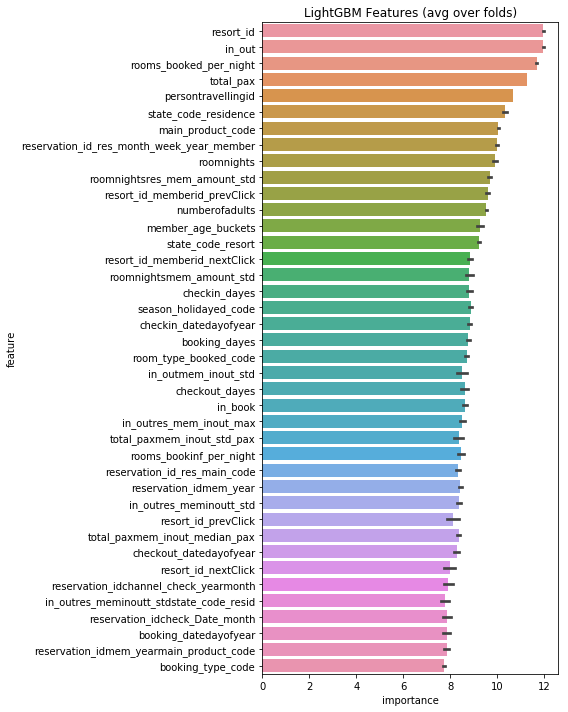

In [57]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

FEATS_EXCLUDED=['target']
pred_test = kfold_lightgbm(X,test,5,train.amount_spent_per_room_night_scaled)

In [59]:
pred_lgb_5_fold = pred_test

In [62]:
pred_ensem= pred_test_lgb_single_model*0.3+pred_catboost_model*0.2+pred_lgb_5_fold*0.3+y_test_fold_cat*0.2

In [163]:
sub = pd.read_csv('sample_submission.csv')

sub.amount_spent_per_room_night_scaled=pred_ensem

sub.to_csv('submission_18_rewrite_parallel.csv',index=None)

#### Feature Selection Code :
Taken from TEARTH's Notebook ~ Amexpert Solution

In [55]:
from tqdm import*

In [56]:
def permutation_feature_selection(model, X_val, y_val, pred_proba=False, rep=3, max_delta_score=0.0):
    from sklearn.metrics import roc_auc_score

    # to do: predict_proba from Booster

    """""
    Perform permutation feature importance calculation for trained LightGBM model. 
    Scorer - ROC AUC. 
    The lower score with permuted feature - the more important feature is. 
    
    Parameters
    ----------
    model : lightGBM.Booster
        Trained model to perform feature importance calculation 
        
    X_val : pandas.DataFrame
        Validation dataset
            
    y_val : pandas.Series 
        Targets for validation dataset
       
    rep : integer (default = 3)
        Number of permutations. More permutations lead to more robust results, but requires more calculation time.
        It is recommended to use values in the range [3; 10].
        
    min_delta_score : float (default = 0.0)
        Minimum delta ins score to keep feature 
        It is recommended to use values in the range [-0.0001; 0].
        
    Output
    ----------
    selected_features : list
        Important features 
        
    importance_df : pandas.DataFrame 
        Records of calculations 
    """""

    print('Permutation feature importance is calculating...')

    columns = []
    scores = []
    stds = []
    score_max = []
    score_min = []

    # calculate the score of model with no permuted features, this is our baseline
    y_hat_nopert = model.predict(X_val)
    score_init = -mean_squared_error(y_val, y_hat_nopert)

    for cc in tqdm(X_val.columns):
        scores_cc = []
        for seed in range(rep):
            # shuffle single column of dataset
            data_temp = X_val.copy()
            data_temp[cc] = data_temp[cc].sample(n=X_val.shape[0], random_state=seed).reset_index(drop=True)

            # make prediction on 'shuffled' dataset and score it
            y_hat = model.predict(data_temp)
            score = -mean_squared_error(y_val, y_hat)
            scores_cc.append(score)

        columns.append(cc)
        scores.append(np.mean(scores_cc) - score_init)
        stds.append(np.std(scores_cc))
        score_max.append(np.max(scores_cc) - score_init)
        score_min.append(np.min(scores_cc) - score_init)

    importance_df = pd.DataFrame({'delta_score_mean': scores,
                                  'delta_score_std': stds,
                                  'delta_score_max': score_max,
                                  'delta_score_min': score_min,
                                  'feature': columns
                                  })
    importance_df = importance_df.sort_values(by='delta_score_mean')
    selected_features = list(importance_df.loc[importance_df['delta_score_mean'] <= max_delta_score, 'feature'])

    print('Permutation feature importance calculation is done. Overall number of features: ', importance_df.shape[0],
          'Number of selected features:', len(selected_features))

    return selected_features, importance_df

In [58]:
test_x = test_x.astype(float)

In [59]:
selected_features, importance_df = permutation_feature_selection(model, test_x, test_y, rep=6)

Permutation feature importance is calculating...



100%|██████████| 88/88 [38:58<00:00, 26.41s/it]


Permutation feature importance calculation is done. Overall number of features:  88 Number of selected features: 74


In [60]:
selected_features

['in_out',
 'total_pax',
 'resort_id',
 'roomnights',
 'main_product_code',
 'checkout_datedayofyear',
 'persontravellingid',
 'numberofadults',
 'resort_id_memberid_prevClick',
 'in_book',
 'state_code_residence',
 'in_outres_meminoutt_mean',
 'resort_id_memberid_nextClick',
 'total_paxmem_inout_mean_pax',
 'checkin_dayes',
 'roomnightsmem_amount_mean',
 'reservation_idmem_year',
 'roomnightsres_mem_amount_std',
 'room_type_booked_code',
 'reservation_id_res_main_code',
 'in_outmem_inout_mean',
 'checkin_datedayofyear',
 'season_holidayed_code',
 'channel_code',
 'booking_type_code',
 'member_age_buckets',
 'reservation_idmem',
 'total_paxmem_res_inout_min_pax',
 'checkout_dayes',
 'numberofchildren',
 'total_paxmem_res_inout_mean_pax',
 'booking_dayes',
 'memberid',
 'reservation_id_x_res',
 'checkout_dateday',
 'in_outmem_inout_std',
 'total_paxmem_inout_std_pax',
 'in_outres_mem_inout_max',
 'reservation_idcheck_Date_month',
 'roomnightsres_mem_amount_mean',
 'checkout_dateweek_day

In [61]:
importance_df

,delta_score_mean,delta_score_std,delta_score_max,delta_score_min,feature
22,-0.463994,0.000613,-4.631294e-01,-4.648738e-01,in_out
38,-0.129431,0.000246,-1.292121e-01,-1.297751e-01,total_pax
30,-0.055005,0.000737,-5.398173e-02,-5.619149e-02,resort_id
34,-0.045337,0.000594,-4.477726e-02,-4.630805e-02,roomnights
23,-0.023719,0.000294,-2.326946e-02,-2.420608e-02,main_product_code
15,-0.019990,0.000041,-1.994635e-02,-2.006684e-02,checkout_datedayofyear
28,-0.017676,0.000416,-1.695882e-02,-1.816312e-02,persontravellingid
26,-0.010939,0.000141,-1.075202e-02,-1.112467e-02,numberofadults
84,-0.009089,0.000143,-8.837406e-03,-9.289125e-03,resort_id_memberid_prevClick
21,-0.007380,0.000053,-7.281405e-03,-7.448653e-03,in_book


#### Run Stacking of Various ML Algos

In [119]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from math import sqrt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import gc

NFOLDS = 3
SEED = 0
NROWS = None
categorical_feats =categor_col


In [120]:
categor_col.remove('memberid')
X.drop('target',axis=1,inplace=True)

ValueError: list.remove(x): x not in list

In [122]:

# for f_ in categorical_feats:
#     data[f_], indexer = pd.factorize(data[f_])
#     test[f_] = indexer.get_indexer(test[f_])
    
# gc.enable()

# y_train = data['TARGET']
# del data['TARGET']

# ###################################
# # PLEASE DON'T DO THIS AT HOME LOL
# # Averaging factorized categorical features defeats my own reasoning
# ################################### 
# prev_cat_features = [
#     f_ for f_ in prev.columns if prev[f_].dtype == 'object'
# ]
# for f_ in prev_cat_features:
#     prev[f_], _ = pd.factorize(prev[f_])
    
# avg_prev = prev.groupby('SK_ID_CURR').mean()
# cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
# avg_prev['nb_app'] = cnt_prev['SK_ID_PREV']
# del avg_prev['SK_ID_PREV']

# x_train = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
# x_test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

# x_train = x_train.fillna(0)
# x_test= x_test.fillna(0)
for i in categor_col:
    X[i]=X[i].astype(int)
    test[i]=test[i].astype(int)    

# excluded_feats = ['SK_ID_CURR']
features = X.columns



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [123]:
x_train = X[features]
x_test = test[features]
ntrain = x_train.shape[0]
ntest = x_test.shape[0]


y_train=y
kf = KFold(n_splits = NFOLDS, shuffle=True, random_state=SEED)



In [125]:

class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        print(x_train.isnull().sum().sum())
        self.clf.fit(x_train.fillna(-999).astype(float), y_train)

    def predict(self, x):
        return self.clf.predict(x.fillna(-999).astype(float))

class CatboostWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
        
class LightGBMWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)


class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))


def get_oof(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        x_te = x_train.loc[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

def get_oof_et(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        x_te = x_train.loc[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test.fillna(-999))

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)



et_params = {
    'n_jobs': 16,
    'n_estimators': 200,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

rf_params = {
    'n_jobs': 16,
    'n_estimators': 200,
    'max_features': 0.2,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'reg:linear',
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'nrounds': 400
}

catboost_params = {
    'iterations': 1400,
    'learning_rate': 0.05,
    'depth': 8,
    'l2_leaf_reg': 17,

    'eval_metric': 'RMSE',
    'od_type': 'Iter',
    'allow_writing_files': False
}

lightgbm_params  = {"objective" : "regression", "metric" : "rmse", 
                    
              "num_leaves" : 31, "learning_rate" : 0.05, "bagging_fraction" : 0.9,
               "bagging_seed" : 0, "num_threads" : 4,"colsample_bytree" : 0.8,"lambda_l1": 25,"min_child_weight" : 44.97
          ,"min_child_samples": 5,'iterations': 500,
             }





In [126]:

xg = XgbWrapper(seed=SEED, params=xgb_params)
#et = SklearnWrapper(clf=ExtraTreesRegressor, seed=SEED, params=et_params)
rf = SklearnWrapper(clf=RandomForestRegressor, seed=SEED, params=rf_params)
cb = CatboostWrapper(clf= CatBoostRegressor, seed = SEED, params=catboost_params)
lg = LightGBMWrapper(clf = LGBMRegressor, seed = SEED, params = lightgbm_params)


In [128]:
xg_oof_train, xg_oof_test = get_oof(xg)
# et_oof_train, et_oof_test = get_oof_et(et)
# print(1)
# rf_oof_train, rf_oof_test = get_oof_et(rf)
print(2)


cb_oof_train, cb_oof_test = get_oof(cb)
print(3)



lg_oof_train, lg_oof_test = get_oof(lg)
print(4)




2
0:	learn: 7.4163577	total: 107ms	remaining: 2m 29s
1:	learn: 7.0568571	total: 263ms	remaining: 3m 3s
2:	learn: 6.7138837	total: 412ms	remaining: 3m 11s
3:	learn: 6.3880818	total: 528ms	remaining: 3m 4s
4:	learn: 6.0792619	total: 661ms	remaining: 3m 4s
5:	learn: 5.7859463	total: 798ms	remaining: 3m 5s
6:	learn: 5.5080233	total: 968ms	remaining: 3m 12s
7:	learn: 5.2454829	total: 1.1s	remaining: 3m 11s
8:	learn: 4.9952675	total: 1.27s	remaining: 3m 17s
9:	learn: 4.7581194	total: 1.38s	remaining: 3m 11s
10:	learn: 4.5343603	total: 1.55s	remaining: 3m 15s
11:	learn: 4.3210761	total: 1.66s	remaining: 3m 11s
12:	learn: 4.1191321	total: 1.82s	remaining: 3m 14s
13:	learn: 3.9287337	total: 2s	remaining: 3m 17s
14:	learn: 3.7473058	total: 2.21s	remaining: 3m 23s
15:	learn: 3.5754783	total: 2.36s	remaining: 3m 23s
16:	learn: 3.4140547	total: 2.58s	remaining: 3m 29s
17:	learn: 3.2613450	total: 2.83s	remaining: 3m 37s
18:	learn: 3.1164968	total: 3.21s	remaining: 3m 53s
19:	learn: 2.9801494	total: 

159:	learn: 0.9694790	total: 27.6s	remaining: 3m 33s
160:	learn: 0.9694154	total: 27.6s	remaining: 3m 32s
161:	learn: 0.9693470	total: 27.7s	remaining: 3m 32s
162:	learn: 0.9692606	total: 27.9s	remaining: 3m 31s
163:	learn: 0.9691457	total: 28s	remaining: 3m 30s
164:	learn: 0.9690642	total: 28.1s	remaining: 3m 30s
165:	learn: 0.9689946	total: 28.2s	remaining: 3m 29s
166:	learn: 0.9688896	total: 28.3s	remaining: 3m 29s
167:	learn: 0.9688050	total: 28.5s	remaining: 3m 28s
168:	learn: 0.9686896	total: 28.7s	remaining: 3m 29s
169:	learn: 0.9685779	total: 29s	remaining: 3m 29s
170:	learn: 0.9685099	total: 29.1s	remaining: 3m 29s
171:	learn: 0.9683734	total: 29.3s	remaining: 3m 28s
172:	learn: 0.9682800	total: 29.4s	remaining: 3m 28s
173:	learn: 0.9681907	total: 29.5s	remaining: 3m 27s
174:	learn: 0.9681271	total: 29.7s	remaining: 3m 27s
175:	learn: 0.9680165	total: 29.8s	remaining: 3m 27s
176:	learn: 0.9679387	total: 29.9s	remaining: 3m 26s
177:	learn: 0.9679106	total: 30s	remaining: 3m 25s

315:	learn: 0.9603018	total: 45.4s	remaining: 2m 35s
316:	learn: 0.9602526	total: 45.5s	remaining: 2m 35s
317:	learn: 0.9602073	total: 45.6s	remaining: 2m 35s
318:	learn: 0.9601657	total: 45.7s	remaining: 2m 34s
319:	learn: 0.9601261	total: 45.8s	remaining: 2m 34s
320:	learn: 0.9600734	total: 45.9s	remaining: 2m 34s
321:	learn: 0.9600023	total: 46s	remaining: 2m 34s
322:	learn: 0.9599284	total: 46.1s	remaining: 2m 33s
323:	learn: 0.9598618	total: 46.2s	remaining: 2m 33s
324:	learn: 0.9598201	total: 46.3s	remaining: 2m 33s
325:	learn: 0.9597675	total: 46.4s	remaining: 2m 33s
326:	learn: 0.9597604	total: 46.5s	remaining: 2m 32s
327:	learn: 0.9597297	total: 46.6s	remaining: 2m 32s
328:	learn: 0.9596973	total: 46.7s	remaining: 2m 32s
329:	learn: 0.9596272	total: 46.8s	remaining: 2m 31s
330:	learn: 0.9596035	total: 46.9s	remaining: 2m 31s
331:	learn: 0.9595492	total: 47s	remaining: 2m 31s
332:	learn: 0.9595398	total: 47.1s	remaining: 2m 31s
333:	learn: 0.9594886	total: 47.3s	remaining: 2m 3

472:	learn: 0.9542810	total: 1m 2s	remaining: 2m 3s
473:	learn: 0.9542777	total: 1m 2s	remaining: 2m 2s
474:	learn: 0.9542704	total: 1m 2s	remaining: 2m 2s
475:	learn: 0.9542459	total: 1m 3s	remaining: 2m 2s
476:	learn: 0.9542133	total: 1m 3s	remaining: 2m 2s
477:	learn: 0.9541701	total: 1m 3s	remaining: 2m 2s
478:	learn: 0.9541390	total: 1m 3s	remaining: 2m 2s
479:	learn: 0.9540874	total: 1m 3s	remaining: 2m 1s
480:	learn: 0.9540317	total: 1m 3s	remaining: 2m 1s
481:	learn: 0.9539962	total: 1m 3s	remaining: 2m 1s
482:	learn: 0.9539920	total: 1m 3s	remaining: 2m 1s
483:	learn: 0.9539693	total: 1m 4s	remaining: 2m 1s
484:	learn: 0.9539461	total: 1m 4s	remaining: 2m 1s
485:	learn: 0.9538878	total: 1m 4s	remaining: 2m 1s
486:	learn: 0.9538512	total: 1m 4s	remaining: 2m
487:	learn: 0.9538173	total: 1m 4s	remaining: 2m
488:	learn: 0.9537354	total: 1m 4s	remaining: 2m
489:	learn: 0.9536999	total: 1m 4s	remaining: 2m
490:	learn: 0.9536752	total: 1m 5s	remaining: 2m
491:	learn: 0.9536455	total

626:	learn: 0.9499802	total: 1m 19s	remaining: 1m 37s
627:	learn: 0.9499703	total: 1m 19s	remaining: 1m 37s
628:	learn: 0.9499446	total: 1m 19s	remaining: 1m 37s
629:	learn: 0.9499010	total: 1m 19s	remaining: 1m 37s
630:	learn: 0.9498730	total: 1m 19s	remaining: 1m 37s
631:	learn: 0.9498550	total: 1m 19s	remaining: 1m 36s
632:	learn: 0.9498265	total: 1m 19s	remaining: 1m 36s
633:	learn: 0.9497925	total: 1m 19s	remaining: 1m 36s
634:	learn: 0.9497559	total: 1m 20s	remaining: 1m 36s
635:	learn: 0.9497308	total: 1m 20s	remaining: 1m 36s
636:	learn: 0.9496666	total: 1m 20s	remaining: 1m 36s
637:	learn: 0.9496661	total: 1m 20s	remaining: 1m 36s
638:	learn: 0.9496466	total: 1m 20s	remaining: 1m 35s
639:	learn: 0.9496167	total: 1m 20s	remaining: 1m 35s
640:	learn: 0.9495755	total: 1m 20s	remaining: 1m 35s
641:	learn: 0.9495718	total: 1m 20s	remaining: 1m 35s
642:	learn: 0.9495464	total: 1m 20s	remaining: 1m 35s
643:	learn: 0.9495039	total: 1m 21s	remaining: 1m 35s
644:	learn: 0.9494675	total:

780:	learn: 0.9456788	total: 1m 35s	remaining: 1m 15s
781:	learn: 0.9456769	total: 1m 35s	remaining: 1m 15s
782:	learn: 0.9456651	total: 1m 35s	remaining: 1m 15s
783:	learn: 0.9456376	total: 1m 35s	remaining: 1m 14s
784:	learn: 0.9456331	total: 1m 35s	remaining: 1m 14s
785:	learn: 0.9456043	total: 1m 35s	remaining: 1m 14s
786:	learn: 0.9455681	total: 1m 35s	remaining: 1m 14s
787:	learn: 0.9455505	total: 1m 35s	remaining: 1m 14s
788:	learn: 0.9455325	total: 1m 35s	remaining: 1m 14s
789:	learn: 0.9455129	total: 1m 36s	remaining: 1m 14s
790:	learn: 0.9454804	total: 1m 36s	remaining: 1m 13s
791:	learn: 0.9454546	total: 1m 36s	remaining: 1m 13s
792:	learn: 0.9454306	total: 1m 36s	remaining: 1m 13s
793:	learn: 0.9453898	total: 1m 36s	remaining: 1m 13s
794:	learn: 0.9453842	total: 1m 36s	remaining: 1m 13s
795:	learn: 0.9453593	total: 1m 36s	remaining: 1m 13s
796:	learn: 0.9453467	total: 1m 36s	remaining: 1m 13s
797:	learn: 0.9452920	total: 1m 36s	remaining: 1m 13s
798:	learn: 0.9452536	total:

937:	learn: 0.9415606	total: 1m 51s	remaining: 54.8s
938:	learn: 0.9415254	total: 1m 51s	remaining: 54.6s
939:	learn: 0.9414940	total: 1m 51s	remaining: 54.5s
940:	learn: 0.9414751	total: 1m 51s	remaining: 54.4s
941:	learn: 0.9414471	total: 1m 51s	remaining: 54.3s
942:	learn: 0.9414264	total: 1m 51s	remaining: 54.1s
943:	learn: 0.9414249	total: 1m 51s	remaining: 54s
944:	learn: 0.9413756	total: 1m 51s	remaining: 53.9s
945:	learn: 0.9413223	total: 1m 52s	remaining: 53.8s
946:	learn: 0.9413021	total: 1m 52s	remaining: 53.7s
947:	learn: 0.9412424	total: 1m 52s	remaining: 53.5s
948:	learn: 0.9412105	total: 1m 52s	remaining: 53.4s
949:	learn: 0.9411867	total: 1m 52s	remaining: 53.3s
950:	learn: 0.9411830	total: 1m 52s	remaining: 53.2s
951:	learn: 0.9411670	total: 1m 52s	remaining: 53s
952:	learn: 0.9411320	total: 1m 52s	remaining: 52.9s
953:	learn: 0.9410894	total: 1m 52s	remaining: 52.8s
954:	learn: 0.9410877	total: 1m 52s	remaining: 52.7s
955:	learn: 0.9410872	total: 1m 53s	remaining: 52.

1093:	learn: 0.9372903	total: 2m 8s	remaining: 35.8s
1094:	learn: 0.9372581	total: 2m 8s	remaining: 35.7s
1095:	learn: 0.9372273	total: 2m 8s	remaining: 35.6s
1096:	learn: 0.9372241	total: 2m 8s	remaining: 35.5s
1097:	learn: 0.9371988	total: 2m 8s	remaining: 35.3s
1098:	learn: 0.9371944	total: 2m 8s	remaining: 35.2s
1099:	learn: 0.9371721	total: 2m 8s	remaining: 35.1s
1100:	learn: 0.9371715	total: 2m 8s	remaining: 35s
1101:	learn: 0.9371415	total: 2m 8s	remaining: 34.8s
1102:	learn: 0.9370983	total: 2m 8s	remaining: 34.7s
1103:	learn: 0.9370615	total: 2m 9s	remaining: 34.6s
1104:	learn: 0.9370266	total: 2m 9s	remaining: 34.5s
1105:	learn: 0.9370222	total: 2m 9s	remaining: 34.4s
1106:	learn: 0.9370093	total: 2m 9s	remaining: 34.2s
1107:	learn: 0.9370063	total: 2m 9s	remaining: 34.1s
1108:	learn: 0.9369837	total: 2m 9s	remaining: 34s
1109:	learn: 0.9369621	total: 2m 9s	remaining: 33.9s
1110:	learn: 0.9369345	total: 2m 9s	remaining: 33.8s
1111:	learn: 0.9369324	total: 2m 9s	remaining: 33.

1246:	learn: 0.9336229	total: 2m 23s	remaining: 17.6s
1247:	learn: 0.9335946	total: 2m 23s	remaining: 17.5s
1248:	learn: 0.9335552	total: 2m 24s	remaining: 17.4s
1249:	learn: 0.9335282	total: 2m 24s	remaining: 17.3s
1250:	learn: 0.9335081	total: 2m 24s	remaining: 17.2s
1251:	learn: 0.9334476	total: 2m 24s	remaining: 17.1s
1252:	learn: 0.9333945	total: 2m 24s	remaining: 17s
1253:	learn: 0.9333622	total: 2m 24s	remaining: 16.8s
1254:	learn: 0.9333256	total: 2m 24s	remaining: 16.7s
1255:	learn: 0.9333238	total: 2m 24s	remaining: 16.6s
1256:	learn: 0.9332736	total: 2m 24s	remaining: 16.5s
1257:	learn: 0.9332513	total: 2m 25s	remaining: 16.4s
1258:	learn: 0.9332219	total: 2m 25s	remaining: 16.3s
1259:	learn: 0.9331827	total: 2m 25s	remaining: 16.1s
1260:	learn: 0.9331515	total: 2m 25s	remaining: 16s
1261:	learn: 0.9331162	total: 2m 25s	remaining: 15.9s
1262:	learn: 0.9330971	total: 2m 25s	remaining: 15.8s
1263:	learn: 0.9330592	total: 2m 25s	remaining: 15.7s
1264:	learn: 0.9330461	total: 2m

1399:	learn: 0.9297602	total: 2m 39s	remaining: 0us
0:	learn: 7.4160622	total: 96.2ms	remaining: 2m 14s
1:	learn: 7.0565687	total: 241ms	remaining: 2m 48s
2:	learn: 6.7135847	total: 360ms	remaining: 2m 47s
3:	learn: 6.3877870	total: 457ms	remaining: 2m 39s
4:	learn: 6.0789982	total: 551ms	remaining: 2m 33s
5:	learn: 5.7856925	total: 668ms	remaining: 2m 35s
6:	learn: 5.5077616	total: 785ms	remaining: 2m 36s
7:	learn: 5.2451972	total: 892ms	remaining: 2m 35s
8:	learn: 4.9949879	total: 1.01s	remaining: 2m 36s
9:	learn: 4.7578493	total: 1.09s	remaining: 2m 31s
10:	learn: 4.5340679	total: 1.22s	remaining: 2m 33s
11:	learn: 4.3208096	total: 1.28s	remaining: 2m 28s
12:	learn: 4.1190661	total: 1.39s	remaining: 2m 28s
13:	learn: 3.9286973	total: 1.53s	remaining: 2m 31s
14:	learn: 3.7472798	total: 1.61s	remaining: 2m 29s
15:	learn: 3.5754979	total: 1.7s	remaining: 2m 27s
16:	learn: 3.4143234	total: 1.84s	remaining: 2m 29s
17:	learn: 3.2615820	total: 1.94s	remaining: 2m 29s
18:	learn: 3.1167531	t

158:	learn: 0.9682391	total: 18.5s	remaining: 2m 24s
159:	learn: 0.9681510	total: 18.6s	remaining: 2m 24s
160:	learn: 0.9680701	total: 18.7s	remaining: 2m 24s
161:	learn: 0.9679724	total: 18.8s	remaining: 2m 23s
162:	learn: 0.9679150	total: 19s	remaining: 2m 23s
163:	learn: 0.9678156	total: 19.1s	remaining: 2m 23s
164:	learn: 0.9676985	total: 19.2s	remaining: 2m 23s
165:	learn: 0.9675946	total: 19.3s	remaining: 2m 23s
166:	learn: 0.9675138	total: 19.4s	remaining: 2m 23s
167:	learn: 0.9674149	total: 19.5s	remaining: 2m 23s
168:	learn: 0.9673259	total: 19.6s	remaining: 2m 23s
169:	learn: 0.9672392	total: 19.8s	remaining: 2m 22s
170:	learn: 0.9671886	total: 19.9s	remaining: 2m 22s
171:	learn: 0.9670715	total: 20s	remaining: 2m 22s
172:	learn: 0.9670005	total: 20.1s	remaining: 2m 22s
173:	learn: 0.9668929	total: 20.2s	remaining: 2m 22s
174:	learn: 0.9667861	total: 20.3s	remaining: 2m 22s
175:	learn: 0.9667048	total: 20.4s	remaining: 2m 22s
176:	learn: 0.9665894	total: 20.5s	remaining: 2m 2

315:	learn: 0.9586673	total: 35.3s	remaining: 2m 1s
316:	learn: 0.9585932	total: 35.4s	remaining: 2m 1s
317:	learn: 0.9585336	total: 35.5s	remaining: 2m
318:	learn: 0.9584406	total: 35.7s	remaining: 2m
319:	learn: 0.9584025	total: 35.8s	remaining: 2m
320:	learn: 0.9583302	total: 35.9s	remaining: 2m
321:	learn: 0.9582860	total: 36s	remaining: 2m
322:	learn: 0.9582284	total: 36.1s	remaining: 2m
323:	learn: 0.9581666	total: 36.2s	remaining: 2m
324:	learn: 0.9581128	total: 36.3s	remaining: 2m
325:	learn: 0.9581115	total: 36.5s	remaining: 2m
326:	learn: 0.9580288	total: 36.6s	remaining: 2m
327:	learn: 0.9579289	total: 37.2s	remaining: 2m 1s
328:	learn: 0.9578996	total: 37.3s	remaining: 2m 1s
329:	learn: 0.9578621	total: 37.4s	remaining: 2m 1s
330:	learn: 0.9578422	total: 37.5s	remaining: 2m 1s
331:	learn: 0.9578086	total: 37.6s	remaining: 2m
332:	learn: 0.9577704	total: 37.7s	remaining: 2m
333:	learn: 0.9577210	total: 37.8s	remaining: 2m
334:	learn: 0.9576794	total: 37.9s	remaining: 2m
335:

473:	learn: 0.9522862	total: 52.1s	remaining: 1m 41s
474:	learn: 0.9522565	total: 52.2s	remaining: 1m 41s
475:	learn: 0.9522221	total: 52.3s	remaining: 1m 41s
476:	learn: 0.9521747	total: 52.4s	remaining: 1m 41s
477:	learn: 0.9521432	total: 52.5s	remaining: 1m 41s
478:	learn: 0.9521413	total: 52.6s	remaining: 1m 41s
479:	learn: 0.9521098	total: 52.7s	remaining: 1m 40s
480:	learn: 0.9520613	total: 52.8s	remaining: 1m 40s
481:	learn: 0.9520012	total: 52.9s	remaining: 1m 40s
482:	learn: 0.9519772	total: 53s	remaining: 1m 40s
483:	learn: 0.9519255	total: 53.1s	remaining: 1m 40s
484:	learn: 0.9519240	total: 53.2s	remaining: 1m 40s
485:	learn: 0.9518794	total: 53.3s	remaining: 1m 40s
486:	learn: 0.9518586	total: 53.4s	remaining: 1m 40s
487:	learn: 0.9518180	total: 53.5s	remaining: 1m 40s
488:	learn: 0.9518171	total: 53.6s	remaining: 1m 39s
489:	learn: 0.9517735	total: 53.7s	remaining: 1m 39s
490:	learn: 0.9517397	total: 53.8s	remaining: 1m 39s
491:	learn: 0.9517078	total: 53.9s	remaining: 1m

630:	learn: 0.9470360	total: 1m 8s	remaining: 1m 23s
631:	learn: 0.9470206	total: 1m 8s	remaining: 1m 23s
632:	learn: 0.9470072	total: 1m 8s	remaining: 1m 23s
633:	learn: 0.9470053	total: 1m 8s	remaining: 1m 23s
634:	learn: 0.9469418	total: 1m 9s	remaining: 1m 24s
635:	learn: 0.9469005	total: 1m 10s	remaining: 1m 24s
636:	learn: 0.9468689	total: 1m 10s	remaining: 1m 24s
637:	learn: 0.9468204	total: 1m 10s	remaining: 1m 24s
638:	learn: 0.9468180	total: 1m 11s	remaining: 1m 24s
639:	learn: 0.9467833	total: 1m 12s	remaining: 1m 25s
640:	learn: 0.9467563	total: 1m 12s	remaining: 1m 26s
641:	learn: 0.9467373	total: 1m 12s	remaining: 1m 26s
642:	learn: 0.9466938	total: 1m 13s	remaining: 1m 26s
643:	learn: 0.9466646	total: 1m 13s	remaining: 1m 26s
644:	learn: 0.9466395	total: 1m 14s	remaining: 1m 26s
645:	learn: 0.9466183	total: 1m 14s	remaining: 1m 27s
646:	learn: 0.9465964	total: 1m 14s	remaining: 1m 27s
647:	learn: 0.9465544	total: 1m 14s	remaining: 1m 27s
648:	learn: 0.9465179	total: 1m 1

783:	learn: 0.9424059	total: 1m 42s	remaining: 1m 20s
784:	learn: 0.9423568	total: 1m 42s	remaining: 1m 20s
785:	learn: 0.9423273	total: 1m 42s	remaining: 1m 20s
786:	learn: 0.9422992	total: 1m 42s	remaining: 1m 19s
787:	learn: 0.9422901	total: 1m 42s	remaining: 1m 19s
788:	learn: 0.9422682	total: 1m 42s	remaining: 1m 19s
789:	learn: 0.9421931	total: 1m 42s	remaining: 1m 19s
790:	learn: 0.9421373	total: 1m 43s	remaining: 1m 19s
791:	learn: 0.9421165	total: 1m 43s	remaining: 1m 19s
792:	learn: 0.9420818	total: 1m 43s	remaining: 1m 19s
793:	learn: 0.9420561	total: 1m 43s	remaining: 1m 18s
794:	learn: 0.9419979	total: 1m 43s	remaining: 1m 18s
795:	learn: 0.9419645	total: 1m 43s	remaining: 1m 18s
796:	learn: 0.9419316	total: 1m 43s	remaining: 1m 18s
797:	learn: 0.9418714	total: 1m 43s	remaining: 1m 18s
798:	learn: 0.9418446	total: 1m 43s	remaining: 1m 18s
799:	learn: 0.9418127	total: 1m 43s	remaining: 1m 18s
800:	learn: 0.9418120	total: 1m 44s	remaining: 1m 17s
801:	learn: 0.9417858	total:

938:	learn: 0.9377981	total: 1m 59s	remaining: 58.8s
939:	learn: 0.9377714	total: 1m 59s	remaining: 58.7s
940:	learn: 0.9377707	total: 1m 59s	remaining: 58.5s
941:	learn: 0.9377385	total: 1m 59s	remaining: 58.4s
942:	learn: 0.9377063	total: 2m	remaining: 58.2s
943:	learn: 0.9376825	total: 2m	remaining: 58.1s
944:	learn: 0.9376357	total: 2m	remaining: 58s
945:	learn: 0.9376070	total: 2m	remaining: 57.8s
946:	learn: 0.9375769	total: 2m	remaining: 57.7s
947:	learn: 0.9375506	total: 2m	remaining: 57.6s
948:	learn: 0.9375031	total: 2m	remaining: 57.4s
949:	learn: 0.9374735	total: 2m	remaining: 57.3s
950:	learn: 0.9374399	total: 2m	remaining: 57.1s
951:	learn: 0.9374009	total: 2m 1s	remaining: 57s
952:	learn: 0.9373992	total: 2m 1s	remaining: 56.9s
953:	learn: 0.9373718	total: 2m 1s	remaining: 56.7s
954:	learn: 0.9373621	total: 2m 1s	remaining: 56.6s
955:	learn: 0.9373029	total: 2m 1s	remaining: 56.5s
956:	learn: 0.9372745	total: 2m 1s	remaining: 56.3s
957:	learn: 0.9372406	total: 2m 1s	rema

1095:	learn: 0.9333036	total: 2m 17s	remaining: 38.2s
1096:	learn: 0.9332741	total: 2m 17s	remaining: 38.1s
1097:	learn: 0.9332484	total: 2m 17s	remaining: 37.9s
1098:	learn: 0.9332077	total: 2m 17s	remaining: 37.8s
1099:	learn: 0.9331716	total: 2m 18s	remaining: 37.7s
1100:	learn: 0.9331361	total: 2m 18s	remaining: 37.6s
1101:	learn: 0.9331111	total: 2m 18s	remaining: 37.4s
1102:	learn: 0.9330924	total: 2m 18s	remaining: 37.3s
1103:	learn: 0.9330572	total: 2m 18s	remaining: 37.2s
1104:	learn: 0.9330143	total: 2m 18s	remaining: 37.1s
1105:	learn: 0.9329817	total: 2m 18s	remaining: 37s
1106:	learn: 0.9329335	total: 2m 19s	remaining: 36.8s
1107:	learn: 0.9329053	total: 2m 19s	remaining: 36.7s
1108:	learn: 0.9328769	total: 2m 19s	remaining: 36.6s
1109:	learn: 0.9328741	total: 2m 19s	remaining: 36.5s
1110:	learn: 0.9328525	total: 2m 19s	remaining: 36.3s
1111:	learn: 0.9328208	total: 2m 19s	remaining: 36.2s
1112:	learn: 0.9327765	total: 2m 19s	remaining: 36.1s
1113:	learn: 0.9327750	total: 

1249:	learn: 0.9290551	total: 2m 40s	remaining: 19.3s
1250:	learn: 0.9290306	total: 2m 40s	remaining: 19.1s
1251:	learn: 0.9289919	total: 2m 40s	remaining: 19s
1252:	learn: 0.9289676	total: 2m 40s	remaining: 18.9s
1253:	learn: 0.9289408	total: 2m 41s	remaining: 18.8s
1254:	learn: 0.9289137	total: 2m 41s	remaining: 18.6s
1255:	learn: 0.9288870	total: 2m 41s	remaining: 18.5s
1256:	learn: 0.9288863	total: 2m 41s	remaining: 18.4s
1257:	learn: 0.9288566	total: 2m 41s	remaining: 18.3s
1258:	learn: 0.9288160	total: 2m 41s	remaining: 18.1s
1259:	learn: 0.9287861	total: 2m 41s	remaining: 18s
1260:	learn: 0.9287570	total: 2m 42s	remaining: 17.9s
1261:	learn: 0.9287341	total: 2m 42s	remaining: 17.8s
1262:	learn: 0.9287110	total: 2m 42s	remaining: 17.6s
1263:	learn: 0.9286629	total: 2m 42s	remaining: 17.5s
1264:	learn: 0.9286010	total: 2m 42s	remaining: 17.4s
1265:	learn: 0.9285838	total: 2m 42s	remaining: 17.3s
1266:	learn: 0.9285804	total: 2m 43s	remaining: 17.1s
1267:	learn: 0.9285488	total: 2m

2:	learn: 6.7129928	total: 361ms	remaining: 2m 48s
3:	learn: 6.3872302	total: 457ms	remaining: 2m 39s
4:	learn: 6.0784280	total: 550ms	remaining: 2m 33s
5:	learn: 5.7851677	total: 671ms	remaining: 2m 35s
6:	learn: 5.5072734	total: 784ms	remaining: 2m 35s
7:	learn: 5.2447532	total: 894ms	remaining: 2m 35s
8:	learn: 4.9949541	total: 1.03s	remaining: 2m 39s
9:	learn: 4.7578237	total: 1.11s	remaining: 2m 35s
10:	learn: 4.5340715	total: 1.25s	remaining: 2m 37s
11:	learn: 4.3208227	total: 1.31s	remaining: 2m 32s
12:	learn: 4.1191915	total: 1.44s	remaining: 2m 33s
13:	learn: 3.9284647	total: 1.56s	remaining: 2m 34s
14:	learn: 3.7470824	total: 1.66s	remaining: 2m 32s
15:	learn: 3.5754124	total: 1.76s	remaining: 2m 32s
16:	learn: 3.4142355	total: 1.9s	remaining: 2m 34s
17:	learn: 3.2615125	total: 2s	remaining: 2m 33s
18:	learn: 3.1166899	total: 2.11s	remaining: 2m 33s
19:	learn: 2.9803263	total: 2.25s	remaining: 2m 35s
20:	learn: 2.8509198	total: 2.35s	remaining: 2m 34s
21:	learn: 2.7294544	tot

160:	learn: 0.9699792	total: 20.4s	remaining: 2m 36s
161:	learn: 0.9698973	total: 20.5s	remaining: 2m 36s
162:	learn: 0.9698107	total: 20.6s	remaining: 2m 36s
163:	learn: 0.9697017	total: 20.8s	remaining: 2m 36s
164:	learn: 0.9696011	total: 20.8s	remaining: 2m 36s
165:	learn: 0.9695443	total: 21s	remaining: 2m 35s
166:	learn: 0.9694685	total: 21.1s	remaining: 2m 35s
167:	learn: 0.9693597	total: 21.2s	remaining: 2m 35s
168:	learn: 0.9692571	total: 21.4s	remaining: 2m 35s
169:	learn: 0.9691636	total: 21.5s	remaining: 2m 35s
170:	learn: 0.9690580	total: 21.7s	remaining: 2m 36s
171:	learn: 0.9689587	total: 21.8s	remaining: 2m 35s
172:	learn: 0.9689059	total: 21.9s	remaining: 2m 35s
173:	learn: 0.9688108	total: 22.1s	remaining: 2m 35s
174:	learn: 0.9687037	total: 22.3s	remaining: 2m 35s
175:	learn: 0.9686331	total: 22.4s	remaining: 2m 35s
176:	learn: 0.9685348	total: 22.6s	remaining: 2m 36s
177:	learn: 0.9684680	total: 22.8s	remaining: 2m 36s
178:	learn: 0.9684145	total: 22.9s	remaining: 2m

315:	learn: 0.9603285	total: 40.3s	remaining: 2m 18s
316:	learn: 0.9603020	total: 40.4s	remaining: 2m 18s
317:	learn: 0.9602846	total: 40.6s	remaining: 2m 18s
318:	learn: 0.9602236	total: 40.8s	remaining: 2m 18s
319:	learn: 0.9601915	total: 41s	remaining: 2m 18s
320:	learn: 0.9601703	total: 41.1s	remaining: 2m 17s
321:	learn: 0.9600822	total: 41.2s	remaining: 2m 17s
322:	learn: 0.9600650	total: 41.4s	remaining: 2m 17s
323:	learn: 0.9599980	total: 41.5s	remaining: 2m 17s
324:	learn: 0.9599213	total: 41.7s	remaining: 2m 17s
325:	learn: 0.9598603	total: 41.8s	remaining: 2m 17s
326:	learn: 0.9598345	total: 41.9s	remaining: 2m 17s
327:	learn: 0.9598152	total: 42s	remaining: 2m 17s
328:	learn: 0.9597856	total: 42.1s	remaining: 2m 17s
329:	learn: 0.9597379	total: 42.2s	remaining: 2m 16s
330:	learn: 0.9596850	total: 42.4s	remaining: 2m 16s
331:	learn: 0.9596453	total: 42.6s	remaining: 2m 16s
332:	learn: 0.9595991	total: 42.7s	remaining: 2m 16s
333:	learn: 0.9595358	total: 42.9s	remaining: 2m 1

472:	learn: 0.9545057	total: 59.2s	remaining: 1m 55s
473:	learn: 0.9544537	total: 59.3s	remaining: 1m 55s
474:	learn: 0.9544262	total: 59.4s	remaining: 1m 55s
475:	learn: 0.9544100	total: 59.5s	remaining: 1m 55s
476:	learn: 0.9543854	total: 59.7s	remaining: 1m 55s
477:	learn: 0.9543393	total: 59.9s	remaining: 1m 55s
478:	learn: 0.9543353	total: 60s	remaining: 1m 55s
479:	learn: 0.9542999	total: 1m	remaining: 1m 55s
480:	learn: 0.9542667	total: 1m	remaining: 1m 55s
481:	learn: 0.9542640	total: 1m	remaining: 1m 54s
482:	learn: 0.9542198	total: 1m	remaining: 1m 54s
483:	learn: 0.9541949	total: 1m	remaining: 1m 54s
484:	learn: 0.9541654	total: 1m	remaining: 1m 54s
485:	learn: 0.9541080	total: 1m	remaining: 1m 54s
486:	learn: 0.9540559	total: 1m 1s	remaining: 1m 54s
487:	learn: 0.9540281	total: 1m 1s	remaining: 1m 54s
488:	learn: 0.9540210	total: 1m 1s	remaining: 1m 54s
489:	learn: 0.9539750	total: 1m 1s	remaining: 1m 54s
490:	learn: 0.9539171	total: 1m 1s	remaining: 1m 54s
491:	learn: 0.95

626:	learn: 0.9491758	total: 1m 19s	remaining: 1m 38s
627:	learn: 0.9491722	total: 1m 19s	remaining: 1m 37s
628:	learn: 0.9491302	total: 1m 19s	remaining: 1m 37s
629:	learn: 0.9491069	total: 1m 19s	remaining: 1m 37s
630:	learn: 0.9490606	total: 1m 20s	remaining: 1m 37s
631:	learn: 0.9490262	total: 1m 20s	remaining: 1m 37s
632:	learn: 0.9490087	total: 1m 20s	remaining: 1m 37s
633:	learn: 0.9489888	total: 1m 20s	remaining: 1m 37s
634:	learn: 0.9489644	total: 1m 20s	remaining: 1m 37s
635:	learn: 0.9489387	total: 1m 20s	remaining: 1m 36s
636:	learn: 0.9489033	total: 1m 20s	remaining: 1m 36s
637:	learn: 0.9488700	total: 1m 20s	remaining: 1m 36s
638:	learn: 0.9488404	total: 1m 21s	remaining: 1m 36s
639:	learn: 0.9488169	total: 1m 21s	remaining: 1m 36s
640:	learn: 0.9487915	total: 1m 21s	remaining: 1m 36s
641:	learn: 0.9487826	total: 1m 21s	remaining: 1m 36s
642:	learn: 0.9487432	total: 1m 21s	remaining: 1m 35s
643:	learn: 0.9486855	total: 1m 21s	remaining: 1m 35s
644:	learn: 0.9486484	total:

779:	learn: 0.9445638	total: 1m 41s	remaining: 1m 20s
780:	learn: 0.9445627	total: 1m 41s	remaining: 1m 20s
781:	learn: 0.9445110	total: 1m 41s	remaining: 1m 20s
782:	learn: 0.9444963	total: 1m 41s	remaining: 1m 20s
783:	learn: 0.9444592	total: 1m 41s	remaining: 1m 19s
784:	learn: 0.9444360	total: 1m 41s	remaining: 1m 19s
785:	learn: 0.9444054	total: 1m 41s	remaining: 1m 19s
786:	learn: 0.9443479	total: 1m 42s	remaining: 1m 19s
787:	learn: 0.9443258	total: 1m 42s	remaining: 1m 19s
788:	learn: 0.9442881	total: 1m 42s	remaining: 1m 19s
789:	learn: 0.9442439	total: 1m 42s	remaining: 1m 19s
790:	learn: 0.9442047	total: 1m 42s	remaining: 1m 19s
791:	learn: 0.9441676	total: 1m 42s	remaining: 1m 19s
792:	learn: 0.9441419	total: 1m 43s	remaining: 1m 18s
793:	learn: 0.9441074	total: 1m 43s	remaining: 1m 18s
794:	learn: 0.9440817	total: 1m 43s	remaining: 1m 18s
795:	learn: 0.9440640	total: 1m 43s	remaining: 1m 18s
796:	learn: 0.9440312	total: 1m 43s	remaining: 1m 18s
797:	learn: 0.9439971	total:

934:	learn: 0.9401943	total: 2m 2s	remaining: 1m 1s
935:	learn: 0.9401457	total: 2m 2s	remaining: 1m
936:	learn: 0.9401219	total: 2m 3s	remaining: 1m
937:	learn: 0.9400598	total: 2m 3s	remaining: 1m
938:	learn: 0.9400217	total: 2m 3s	remaining: 1m
939:	learn: 0.9399953	total: 2m 3s	remaining: 1m
940:	learn: 0.9399825	total: 2m 3s	remaining: 1m
941:	learn: 0.9399428	total: 2m 3s	remaining: 1m
942:	learn: 0.9399180	total: 2m 3s	remaining: 1m
943:	learn: 0.9398996	total: 2m 3s	remaining: 59.9s
944:	learn: 0.9398733	total: 2m 4s	remaining: 59.7s
945:	learn: 0.9398520	total: 2m 4s	remaining: 59.6s
946:	learn: 0.9398173	total: 2m 4s	remaining: 59.5s
947:	learn: 0.9397996	total: 2m 4s	remaining: 59.3s
948:	learn: 0.9397765	total: 2m 4s	remaining: 59.2s
949:	learn: 0.9397528	total: 2m 4s	remaining: 59s
950:	learn: 0.9397397	total: 2m 4s	remaining: 58.9s
951:	learn: 0.9396947	total: 2m 4s	remaining: 58.8s
952:	learn: 0.9396891	total: 2m 4s	remaining: 58.6s
953:	learn: 0.9396541	total: 2m 5s	rem

1090:	learn: 0.9357269	total: 2m 22s	remaining: 40.4s
1091:	learn: 0.9357021	total: 2m 22s	remaining: 40.2s
1092:	learn: 0.9356715	total: 2m 22s	remaining: 40.1s
1093:	learn: 0.9356464	total: 2m 22s	remaining: 40s
1094:	learn: 0.9356130	total: 2m 23s	remaining: 39.9s
1095:	learn: 0.9355733	total: 2m 23s	remaining: 39.7s
1096:	learn: 0.9355512	total: 2m 23s	remaining: 39.6s
1097:	learn: 0.9354981	total: 2m 23s	remaining: 39.5s
1098:	learn: 0.9354672	total: 2m 23s	remaining: 39.3s
1099:	learn: 0.9354123	total: 2m 23s	remaining: 39.2s
1100:	learn: 0.9353786	total: 2m 23s	remaining: 39.1s
1101:	learn: 0.9353312	total: 2m 24s	remaining: 39s
1102:	learn: 0.9352847	total: 2m 24s	remaining: 38.8s
1103:	learn: 0.9352807	total: 2m 24s	remaining: 38.7s
1104:	learn: 0.9352343	total: 2m 24s	remaining: 38.6s
1105:	learn: 0.9351979	total: 2m 24s	remaining: 38.5s
1106:	learn: 0.9351846	total: 2m 24s	remaining: 38.3s
1107:	learn: 0.9351506	total: 2m 24s	remaining: 38.2s
1108:	learn: 0.9351121	total: 2m

1244:	learn: 0.9313843	total: 2m 43s	remaining: 20.3s
1245:	learn: 0.9313723	total: 2m 43s	remaining: 20.2s
1246:	learn: 0.9313638	total: 2m 43s	remaining: 20.1s
1247:	learn: 0.9313503	total: 2m 43s	remaining: 19.9s
1248:	learn: 0.9312996	total: 2m 43s	remaining: 19.8s
1249:	learn: 0.9312877	total: 2m 43s	remaining: 19.7s
1250:	learn: 0.9312475	total: 2m 43s	remaining: 19.5s
1251:	learn: 0.9312243	total: 2m 44s	remaining: 19.4s
1252:	learn: 0.9312035	total: 2m 44s	remaining: 19.3s
1253:	learn: 0.9311780	total: 2m 44s	remaining: 19.1s
1254:	learn: 0.9311257	total: 2m 44s	remaining: 19s
1255:	learn: 0.9310948	total: 2m 44s	remaining: 18.9s
1256:	learn: 0.9310393	total: 2m 44s	remaining: 18.7s
1257:	learn: 0.9310223	total: 2m 44s	remaining: 18.6s
1258:	learn: 0.9310001	total: 2m 44s	remaining: 18.5s
1259:	learn: 0.9309760	total: 2m 44s	remaining: 18.3s
1260:	learn: 0.9309725	total: 2m 45s	remaining: 18.2s
1261:	learn: 0.9309688	total: 2m 45s	remaining: 18.1s
1262:	learn: 0.9309526	total: 

1397:	learn: 0.9270605	total: 3m 2s	remaining: 261ms
1398:	learn: 0.9270310	total: 3m 2s	remaining: 131ms
1399:	learn: 0.9270011	total: 3m 2s	remaining: 0us
3
4


In [134]:
print("XG-CV: {}".format(sqrt(mean_squared_error(y_train, xg_oof_train))))
#print("ET-CV: {}".format(sqrt(mean_squared_error(y_train.head(100), et_oof_train))))
#print("RF-CV: {}".format(sqrt(mean_squared_error(y_train.head(100), rf_oof_train))))
print("CB-CV: {}".format(sqrt(mean_squared_error(y_train, cb_oof_train))))
print("LG-CV: {}".format(sqrt(mean_squared_error(y_train, lg_oof_train))))


x_train = np.concatenate(( xg_oof_train,lg_oof_train, cb_oof_train), axis=1)
x_test = np.concatenate((xg_oof_test,lg_oof_test, cb_oof_test), axis=1)

print("{},{}".format(x_train.shape, x_test.shape))

logistic_regression = LinearRegression()
logistic_regression.fit(x_train,y_train)





XG-CV: 0.9664293052563901
CB-CV: 0.9656478784721583
LG-CV: 0.9719571115493982
(341424, 3),(146765, 3)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [135]:
pred = logistic_regression.predict(x_test)



In [136]:
logistic_regression.coef_

array([0.38462835, 0.02879436, 0.60768349])

## Ensembling it with previous algos

In [153]:
sub = pd.read_csv('sample_submission.csv')

sub.amount_spent_per_room_night_scaled=pred_ensem*0.8+pred*0.2
sub.to_csv('xgb_cat_ensemb.csv',index=None)




